# Database source

### [Kaggle movie database](https://www.kaggle.com/shubhammehta21/movie-lens-small-latest-dataset?select=movies.csv)

# Import modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

In [3]:
from wordcloud import WordCloud

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [79]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [49]:
df_movies = pd.read_csv('movies.csv')
df_ratings = pd.read_csv('ratings.csv')

In [50]:
df_movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [51]:
df_ratings.head()

userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

In [52]:
df=df_movies.merge(df_ratings,on="movieId")

In [53]:
df.head()

movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating   timestamp  
0       1     4.0   964982703  
1       5     4.0   847434962  
2       7     4.5  1106635946  
3      15     2.5  1510577970  
4      17     4.5  1305696483

##### Checking up missing values

<AxesSubplot:>

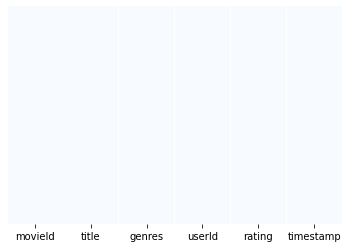

In [10]:
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

<p>Drop timestamp column </p>

In [54]:
df.drop('timestamp',axis=1,inplace=True)

# Explore data

In [12]:
most_rated = df.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

In [13]:
bar = px.bar(x=most_rated.index,
             y=most_rated.values,
             color=most_rated.values,
             title='Most rated movies')

bar.update_layout(xaxis_title='Movies', 
                  yaxis_title='No. of ratings',
                  coloraxis_showscale=False)
bar.show()

In [14]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

rating
title                                          
'71 (2014)                                  4.0
'Hellboy': The Seeds of Creation (2004)     4.0
'Round Midnight (1986)                      3.5
'Salem's Lot (2004)                         5.0
'Til There Was You (1997)                   4.0

In [15]:
ratings['num_ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

rating  num_ratings
title                                                       
'71 (2014)                                  4.0            1
'Hellboy': The Seeds of Creation (2004)     4.0            1
'Round Midnight (1986)                      3.5            2
'Salem's Lot (2004)                         5.0            1
'Til There Was You (1997)                   4.0            2

<AxesSubplot:title={'center':'No. of ratings'}>

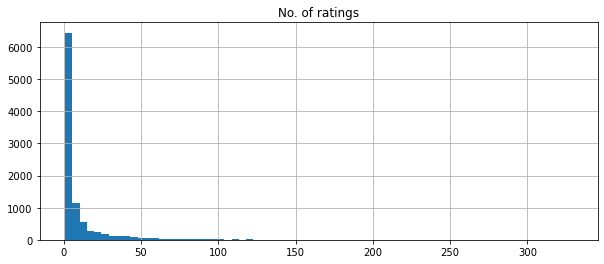

In [16]:
plt.figure(figsize=(10,4))
plt.title('No. of ratings')
ratings['num_ratings'].hist(bins=70)

<AxesSubplot:title={'center':'Average rating'}>

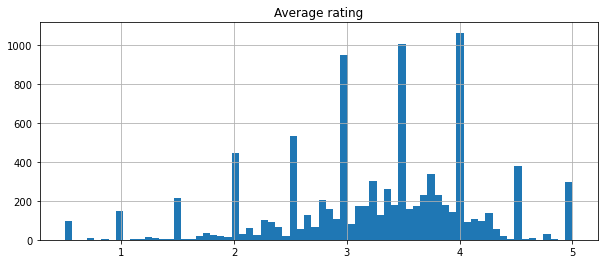

In [17]:
plt.figure(figsize=(10,4))
plt.title('Average rating')
ratings['rating'].hist(bins=70)

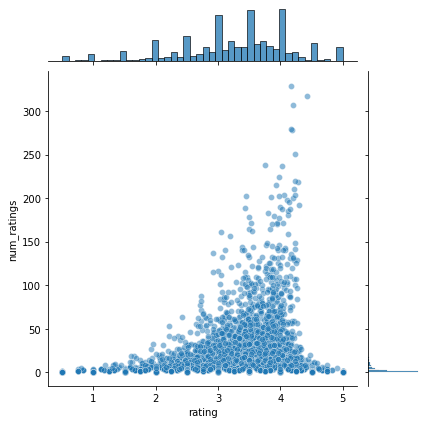

In [18]:
sns.jointplot(x='rating',y='num_ratings',data=ratings,alpha=0.5)

## Basic Recomendation of a movie based on correlation

In [19]:
mat = df.pivot_table(index='userId',columns='title',values='rating')
mat.head()

title   '71 (2014)  'Hellboy': The Seeds of Creation (2004)  \
userId                                                        
1              NaN                                      NaN   
2              NaN                                      NaN   
3              NaN                                      NaN   
4              NaN                                      NaN   
5              NaN                                      NaN   

title   'Round Midnight (1986)  'Salem's Lot (2004)  \
userId                                                
1                          NaN                  NaN   
2                          NaN                  NaN   
3                          NaN                  NaN   
4                          NaN                  NaN   
5                          NaN                  NaN   

title   'Til There Was You (1997)  'Tis the Season for Love (2015)  \
userId                                                               
1                             NaN                              NaN   
2                             NaN                              NaN   
3                             NaN                              NaN   
4                             NaN                              NaN   
5                             NaN                              NaN   

title   'burbs, The (1989)  'night Mother (1986)  (500) Days of Summer (2009)  \
userId                                                                          
1                      NaN                   NaN                          NaN   
2                      NaN                   NaN                          NaN   
3                      NaN                   NaN                          NaN   
4                      NaN                   NaN                          NaN   
5                      NaN                   NaN                          NaN   

title   *batteries not included (1987)  ...  Zulu (2013)  [REC] (2007)  \
userId                                  ...                              
1                                  NaN  ...          NaN           NaN   
2                                  NaN  ...          NaN           NaN   
3                                  NaN  ...          NaN           NaN   
4                                  NaN  ...          NaN           NaN   
5                                  NaN  ...          NaN           NaN   

title   [REC]² (2009)  [REC]³ 3 Génesis (2012)  \
userId                                           
1                 NaN                      NaN   
2                 NaN                      NaN   
3                 NaN                      NaN   
4                 NaN                      NaN   
5                 NaN                      NaN   

title   anohana: The Flower We Saw That Day - The Movie (2013)  \
userId                                                           
1                                                     NaN        
2                                                     NaN        
3                                                     NaN        
4                                                     NaN        
5                                                     NaN        

title   eXistenZ (1999)  xXx (2002)  xXx: State of the Union (2005)  \
userId                                                                
1                   NaN         NaN                             NaN   
2                   NaN         NaN                             NaN   
3                   NaN         NaN                             NaN   
4                   NaN         NaN                             NaN   
5                   NaN         NaN                             NaN   

title   ¡Three Amigos! (1986)  À nous la liberté (Freedom for Us) (1931)  
userId                                                                    
1                         4.0                                        NaN  
2                         NaN                            

###### most rated movie with corresponding avg rating

In [20]:
ratings.sort_values('num_ratings',ascending=False).head(10)

rating  num_ratings
title                                                           
Forrest Gump (1994)                        4.164134          329
Shawshank Redemption, The (1994)           4.429022          317
Pulp Fiction (1994)                        4.197068          307
Silence of the Lambs, The (1991)           4.161290          279
Matrix, The (1999)                         4.192446          278
Star Wars: Episode IV - A New Hope (1977)  4.231076          251
Jurassic Park (1993)                       3.750000          238
Braveheart (1995)                          4.031646          237
Terminator 2: Judgment Day (1991)          3.970982          224
Schindler's List (1993)                    4.225000          220

###### Investigate a movie to see the recomendations:
- Forrest Gump (1994)	

In [21]:
forrest_user_ratings = mat['Forrest Gump (1994)']
forrest_user_ratings.head()

userId
1    4.0
2    NaN
3    NaN
4    NaN
5    NaN
Name: Forrest Gump (1994), dtype: float64

In [22]:
similar_to_forrest = mat.corrwith(forrest_user_ratings)

F:\Ana3\envs\tensorflow_env\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning:

Degrees of freedom <= 0 for slice

F:\Ana3\envs\tensorflow_env\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning:

divide by zero encountered in true_divide



In [23]:
corr_forrest = pd.DataFrame(similar_to_forrest,columns=['Correlation'])
corr_forrest.dropna(inplace=True)
corr_forrest.head(10)

Correlation
title                                         
'burbs, The (1989)                    0.197712
(500) Days of Summer (2009)           0.234095
*batteries not included (1987)        0.892710
...And Justice for All (1979)         0.928571
10 Cent Pistol (2015)                -1.000000
10 Cloverfield Lane (2016)            0.752057
10 Items or Less (2006)              -1.000000
10 Things I Hate About You (1999)     0.088009
10,000 BC (2008)                     -0.143823
101 Dalmatians (1996)                 0.381438

In [24]:
corr_forrest.sort_values('Correlation',ascending=False).head(10)

Correlation
title                                                 
Lost & Found (1999)                                1.0
Century of the Self, The (2002)                    1.0
The 5th Wave (2016)                                1.0
Play Time (a.k.a. Playtime) (1967)                 1.0
Memories (Memorîzu) (1995)                         1.0
Playing God (1997)                                 1.0
Killers (2010)                                     1.0
Girl Walks Home Alone at Night, A (2014)           1.0
Tampopo (1985)                                     1.0
Cercle Rouge, Le (Red Circle, The) (1970)          1.0

In [25]:
corr_forrest = corr_forrest.join(ratings['num_ratings'])
corr_forrest.head()

Correlation  num_ratings
title                                                   
'burbs, The (1989)                 0.197712           17
(500) Days of Summer (2009)        0.234095           42
*batteries not included (1987)     0.892710            7
...And Justice for All (1979)      0.928571            3
10 Cent Pistol (2015)             -1.000000            2

In [26]:
corr_forrest[corr_forrest['num_ratings']>50].sort_values('Correlation',ascending=False).head(10)

Correlation  num_ratings
title                                              
Forrest Gump (1994)           1.000000          329
Mr. Holland's Opus (1995)     0.652144           80
Pocahontas (1995)             0.550118           68
Grumpier Old Men (1995)       0.534682           52
Caddyshack (1980)             0.520328           52
Few Good Men, A (1992)        0.517146           57
Field of Dreams (1989)        0.503845           56
Big (1988)                    0.492351           91
Hook (1991)                   0.484676           53
Good Will Hunting (1997)      0.484042          141

#### Wrap up all the analysis to obtain the correlation list in one single function to turn the code more generic

In [27]:
def get_recomendation(movie_title,cut_off_rate,num_movies):
    """
    A function that receives as arguments a specific movie title and the minimum limit of number of ratings (cut_off_rate) and
    the number of movies we want in the final list (num_movies)
    """
    movie_user_ratings = mat[movie_title]
    similar_to_movie = mat.corrwith(movie_user_ratings)
    corr_movie = pd.DataFrame(similar_to_movie,columns=['Correlation'])
    corr_movie.dropna(inplace=True)
    corr_movie = corr_movie.join(ratings['num_ratings'])
    return corr_movie[corr_movie['num_ratings']>cut_off_rate].sort_values('Correlation',ascending=False).head(num_movies)

In [28]:
get_recomendation('Forrest Gump (1994)',50,10)

F:\Ana3\envs\tensorflow_env\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning:

Degrees of freedom <= 0 for slice

F:\Ana3\envs\tensorflow_env\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning:

divide by zero encountered in true_divide



Correlation  num_ratings
title                                              
Forrest Gump (1994)           1.000000          329
Mr. Holland's Opus (1995)     0.652144           80
Pocahontas (1995)             0.550118           68
Grumpier Old Men (1995)       0.534682           52
Caddyshack (1980)             0.520328           52
Few Good Men, A (1992)        0.517146           57
Field of Dreams (1989)        0.503845           56
Big (1988)                    0.492351           91
Hook (1991)                   0.484676           53
Good Will Hunting (1997)      0.484042          141

In [29]:
get_recomendation('Jurassic Park (1993)',50,10)

F:\Ana3\envs\tensorflow_env\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning:

Degrees of freedom <= 0 for slice

F:\Ana3\envs\tensorflow_env\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning:

divide by zero encountered in true_divide



Correlation  num_ratings
title                                                               
Jurassic Park (1993)                           1.000000          238
Field of Dreams (1989)                         0.643783           56
Kung Fu Panda (2008)                           0.634736           54
Lethal Weapon (1987)                           0.608894           75
The Hunger Games (2012)                        0.591129           54
Bug's Life, A (1998)                           0.540132           92
Outbreak (1995)                                0.533780          101
Sting, The (1973)                              0.524691           64
Ghostbusters (a.k.a. Ghost Busters) (1984)     0.522286          120
Top Gun (1986)                                 0.515869           83

# Content-based 

###### Generate wordcloud

In [30]:
movies = df['genres'].tolist()

In [31]:
sentences_as_one_string =" ".join(movies)

(-0.5, 399.5, 199.5, -0.5)

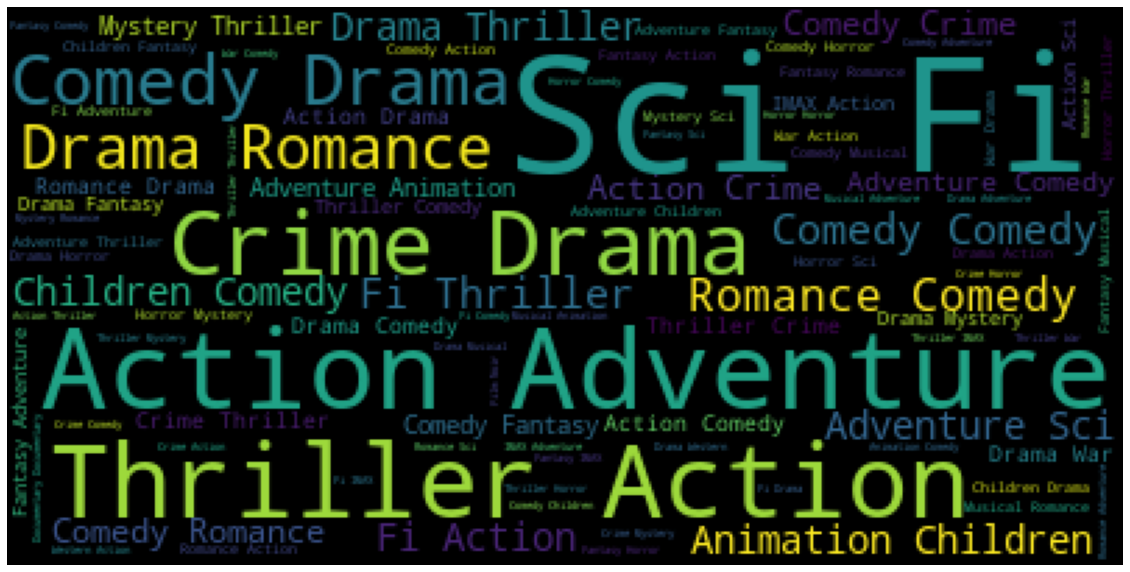

In [32]:
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(sentences_as_one_string))
plt.axis('off')

In [33]:
df.head()

movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating  
0       1     4.0  
1       5     4.0  
2       7     4.5  
3      15     2.5  
4      17     4.5

In [34]:
df.shape

(100836, 5)

In [35]:
df2 = df.drop_duplicates(subset=['title'], keep='last')
df2.head()

movieId                               title  \
214        1                    Toy Story (1995)   
324        2                      Jumanji (1995)   
376        3             Grumpier Old Men (1995)   
383        4            Waiting to Exhale (1995)   
432        5  Father of the Bride Part II (1995)   

                                          genres  userId  rating  
214  Adventure|Animation|Children|Comedy|Fantasy     610     5.0  
324                   Adventure|Children|Fantasy     608     2.0  
376                               Comedy|Romance     608     2.0  
383                         Comedy|Drama|Romance     600     1.5  
432                                       Comedy     604     3.0

In [36]:
cv = CountVectorizer()

In [37]:
count_matrix = cv.fit_transform(df2['genres'])

In [38]:
count_matrix.shape

(9719, 24)

In [39]:
cosine_sim = cosine_similarity(count_matrix)

In [40]:
df2

movieId                                      title  \
214           1                           Toy Story (1995)   
324           2                             Jumanji (1995)   
376           3                    Grumpier Old Men (1995)   
383           4                   Waiting to Exhale (1995)   
432           5         Father of the Bride Part II (1995)   
...         ...                                        ...   
100831   193581  Black Butler: Book of the Atlantic (2017)   
100832   193583               No Game No Life: Zero (2017)   
100833   193585                               Flint (2017)   
100834   193587        Bungo Stray Dogs: Dead Apple (2018)   
100835   193609        Andrew Dice Clay: Dice Rules (1991)   

                                             genres  userId  rating  
214     Adventure|Animation|Children|Comedy|Fantasy     610     5.0  
324                      Adventure|Children|Fantasy     608     2.0  
376                                  Comedy|Romance     608     2.0  
383                            Comedy|Drama|Romance     600     1.5  
432                                          Comedy     604     3.0  
...                                             ...     ...     ...  
100831              Action|Animation|Comedy|Fantasy     184     4.0  
100832                     Animation|Comedy|Fantasy     184     3.5  
100833                                        Drama     184     3.5  
100834                             Action|Animation     184     3.5  
100835                                       Comedy     331     4.0  

[9719 rows x 5 columns]

In [41]:
indices = pd.Series(df2.index, index=df2['title'])

In [42]:
def get_recomendation2(movie_title,nr_recomendations):
    index=indices[movie_title]
    sim_scores = list(enumerate(cosine_sim[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:nr_recomendations] 
    movie_indices = [index[0] for index in sim_scores]
    return df2['title'].iloc[movie_indices]

In [43]:
get_recomendation2('Toy Story (1995)',10)

2615                   Big Green, The (1995)
3041                Dunston Checks In (1996)
6625     Heavyweights (Heavy Weights) (1995)
11078                     Richie Rich (1994)
15185             Little Rascals, The (1994)
15352                      Home Alone (1990)
19404                 Harriet the Spy (1996)
19716                    House Arrest (1996)
20099                       First Kid (1996)
Name: title, dtype: object

# Collaborative-filtering

##### In collaborative filtering there are two types of recomendation for memory based CF: 
- user based CF: the system recommends products to a user that similar users liked
- item based CF: the system recommends items based on their similarity with the items that the target user rated
- These models presents problems related with scalability and sparsity.

#### To avoid these problems, Matrix factorization (MF) was adopted in here based on the Single value decomposition method was adopted by using a latent factor model to capture the similarity between users and items. 
- For more info check here: [Recommended Systems](https://blog.cambridgespark.com/nowadays-recommender-systems-are-used-to-personalize-your-experience-on-the-web-telling-you-what-120f39b89c3c)

In [55]:
df.drop('genres',axis=1,inplace=True)

In [56]:
df

movieId                                      title  userId  rating
0             1                           Toy Story (1995)       1     4.0
1             1                           Toy Story (1995)       5     4.0
2             1                           Toy Story (1995)       7     4.5
3             1                           Toy Story (1995)      15     2.5
4             1                           Toy Story (1995)      17     4.5
...         ...                                        ...     ...     ...
100831   193581  Black Butler: Book of the Atlantic (2017)     184     4.0
100832   193583               No Game No Life: Zero (2017)     184     3.5
100833   193585                               Flint (2017)     184     3.5
100834   193587        Bungo Stray Dogs: Dead Apple (2018)     184     3.5
100835   193609        Andrew Dice Clay: Dice Rules (1991)     331     4.0

[100836 rows x 4 columns]

In [60]:
reader = Reader()

In [177]:
data = Dataset.load_from_df(df[['userId','movieId','rating']],reader)

In [69]:
svd = SVD()
cross_validate(svd, data, measures = ['RMSE','MAE'],cv=5)

{'test_rmse': array([0.87516656, 0.86645372, 0.87273085, 0.87357869, 0.87874729]),
 'test_mae': array([0.67174024, 0.66718133, 0.6687765 , 0.67121384, 0.67583373]),
 'fit_time': (5.920198440551758,
  6.4302849769592285,
  5.781986713409424,
  5.8627610206604,
  5.565058469772339),
 'test_time': (0.14661121368408203,
  0.20474982261657715,
  0.28423571586608887,
  0.1326463222503662,
  0.1964735984802246)}

In [70]:
train = data.build_full_trainset()
svd.fit(train)

In [137]:
list_of_users = df['userId'].values.tolist()

In [103]:
df[df['userId'] == 1][['movieId','rating']]

movieId  rating
0            1     4.0
325          3     4.0
433          6     4.0
2107        47     5.0
2379        50     5.0
...        ...     ...
56816     3744     4.0
57276     3793     5.0
57457     3809     4.0
59170     4006     4.0
65533     5060     5.0

[232 rows x 2 columns]

In [114]:
array = df[df['userId'] == 1][['movieId','rating']].values

In [117]:
real = []
estimated =[]
for i in range(len(array)):
    pred = svd.predict(1, df[df['userId'] == 1][['movieId','rating']].values[i][0],
                   df[df['userId'] == 1][['movieId','rating']].values[i][1], 
                   verbose=False) # real is in 3rd position and pred in 4th
    real.append(pred[2])
    estimated.append(pred[3])

In [121]:
results = pd.DataFrame(list(zip(real,estimated)),
                       columns = ['real','estimated'])

In [126]:
results['diff'] = results['real'] - results['estimated']

<AxesSubplot:title={'center':'Differences between the real and estimated'}, xlabel='diff', ylabel='Count'>

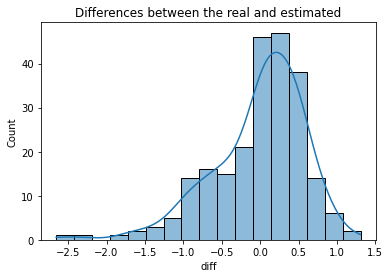

In [129]:
plt.title('Differences between the real and estimated')
sns.histplot(results['diff'],kde=True)

##### Function to pick any user of the list 

In [174]:
def prediction_svd(no_user):
    if no_user in list_of_users:
        array = df[df['userId'] == no_user][['movieId','rating']].values
        real = []
        estimated =[]
        for i in range(len(array)):
            pred = svd.predict(no_user,array[i][0],array[i][1], verbose=False) # real is in 3rd position and pred in 4th
            real.append(pred[2])
            estimated.append(pred[3])
        results = pd.DataFrame(list(zip(real,estimated)), columns = ['real','estimated'])
        results['diff'] = results['real'] - results['estimated'] # check the differences between real and predicted
        return results
    else:
        print("You've picked a user out of the list")

In [175]:
prediction_svd(2)

real  estimated      diff
0    3.0   4.145403 -1.145403
1    4.0   3.951156  0.048844
2    4.5   4.279037  0.220963
3    4.0   4.028652 -0.028652
4    4.0   4.112405 -0.112405
5    3.5   3.784942 -0.284942
6    4.0   3.722361  0.277639
7    4.0   4.205686 -0.205686
8    4.5   4.210340  0.289660
9    5.0   4.044491  0.955509
10   4.5   4.243024  0.256976
11   3.0   3.763153 -0.763153
12   4.0   3.955494  0.044506
13   3.0   3.727711 -0.727711
14   4.0   4.057449 -0.057449
15   4.5   4.129120  0.370880
16   5.0   4.258707  0.741293
17   4.0   3.998574  0.001426
18   5.0   3.914502  1.085498
19   3.5   3.811565 -0.311565
20   2.5   3.306822 -0.806822
21   3.5   3.888079 -0.388079
22   5.0   4.324533  0.675467
23   3.0   3.968626 -0.968626
24   4.0   4.260965 -0.260965
25   2.0   3.262036 -1.262036
26   3.5   3.898886 -0.398886
27   5.0   4.014692  0.985308
28   5.0   3.903857  1.096143